In [1]:
import scanpy
import anndata
from matplotlib import pyplot
import hdf5plugin
import numpy
import scvelo
import seaborn

/home/love/miniconda3/envs/masters_project/lib/python3.13/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/home/love/miniconda3/envs/masters_project/lib/python3.13/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/home/love/miniconda3/envs/masters_project/lib/python3.13/site-packages/scanpy/readwrite.py:16: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):


In [6]:
# Read input file

scanpy.settings.set_figure_params(dpi=100, facecolor="white")

seq_file_path = "RNA Sequencing Data/splice_counts.h5ad"
adata = scanpy.read_h5ad(seq_file_path)
print(adata)

AnnData object with n_obs × n_vars = 14262 × 34183
    obs: 'sample', 'group', 'day'
    var: 'ensembl_id', 'gene_symbol'
    layers: 'spliced', 'unspliced'


In [3]:
# print(adata[:, "Krtdap"].layers["spliced"])
print((adata.layers["spliced"]>0).sum())
print((adata.layers["unspliced"]>0).sum())
#print(adata[:, "Krtdap"].X.sum())
print((adata[:, "Krtdap"].X).mean())
print(adata.var_names[adata.var_names.str.startswith("Hic2")])

24505026
23403327
7.426728369092693
Index(['Hic2'], dtype='object', name='gene_name')


Mitochondrial genes:
Index(['mt-Nd1', 'mt-Nd2', 'mt-Co1', 'mt-Co2', 'mt-Atp8', 'mt-Atp6', 'mt-Co3',
       'mt-Nd3', 'mt-Nd4l', 'mt-Nd4', 'mt-Nd5', 'mt-Nd6', 'mt-Cytb'],
      dtype='object', name='gene_name')


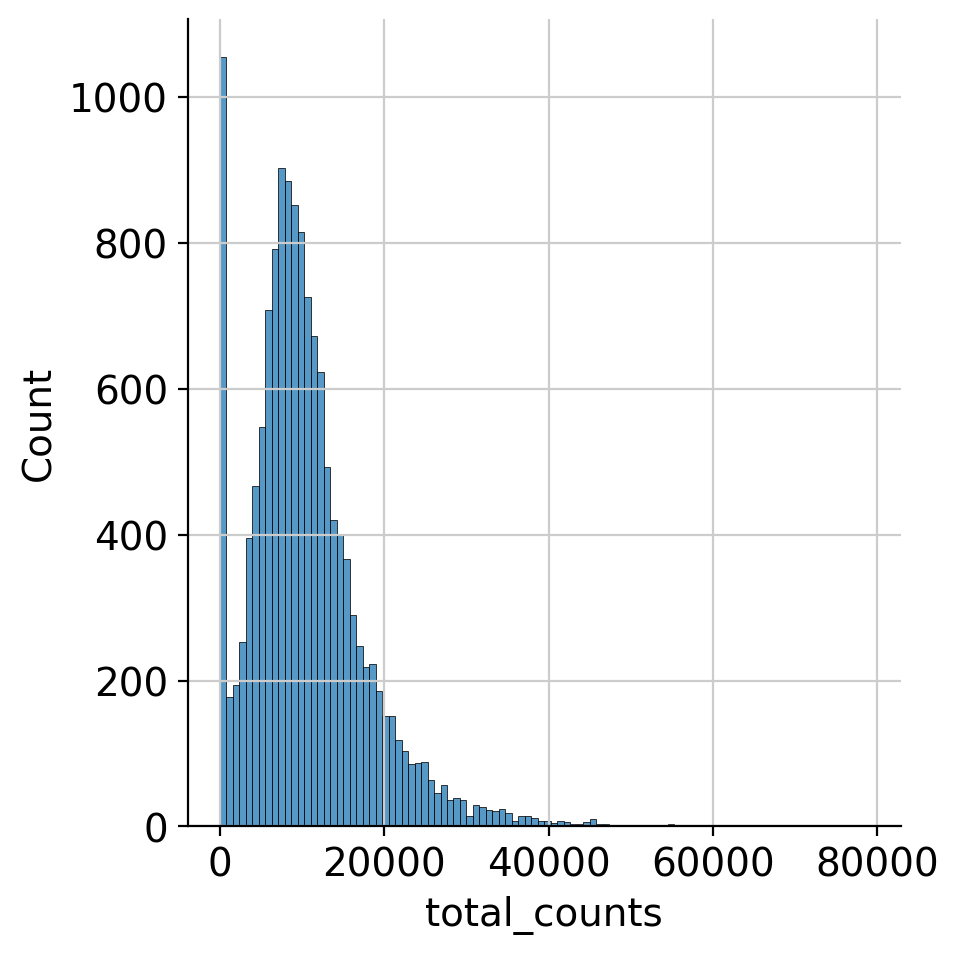

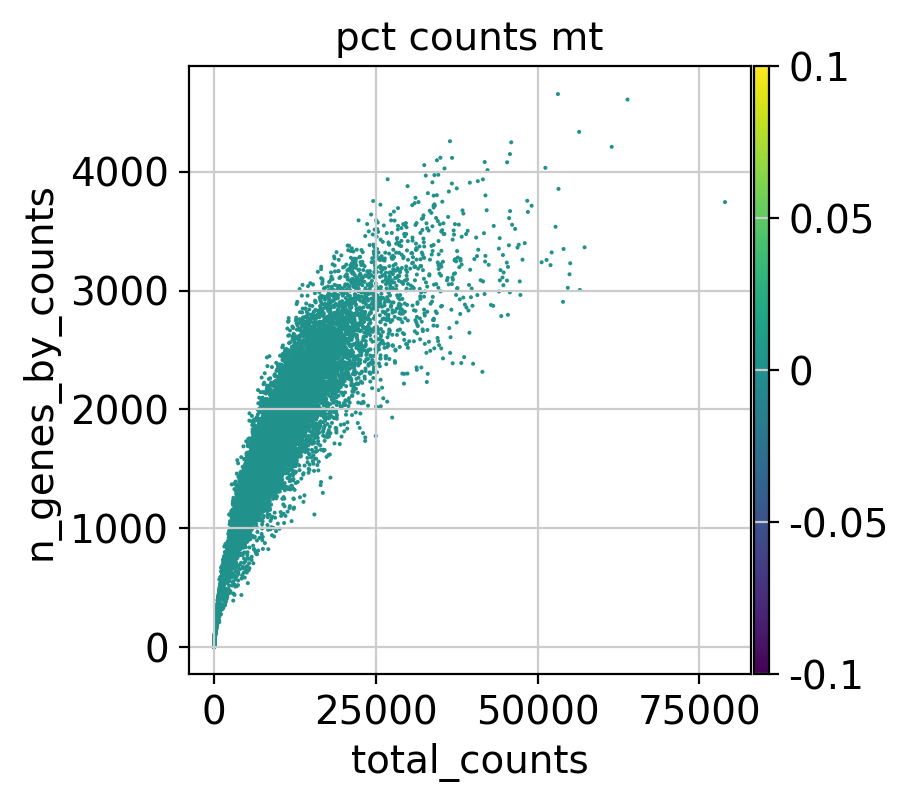

In [7]:
# Quality control

# Get mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("mt-")
scanpy.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], inplace=True, percent_top=[], log1p=False
)
print("Mitochondrial genes:")
print(adata.var_names[adata.var["mt"]])

histogram = seaborn.displot(adata.obs["total_counts"], bins=100, kde=False)
scatter = scanpy.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [8]:
# Filter and normalize

# Filter cells by counts per cell, total counts and percent mitochondrial
included_cells = (adata.obs["n_genes_by_counts"] >= 200)*(adata.obs['total_counts'] <= 150000)*(adata.obs['pct_counts_mt'] < 10)
adata = adata[included_cells]

# Filter genes by spliced and unspliced counts and normalize
scvelo.pp.filter_and_normalize(adata, min_shared_counts=20)

print("Filtered Anndata object:\n{adata}")

Filtered out 24652 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.


/home/love/miniconda3/envs/masters_project/lib/python3.13/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


Logarithmized X.
Filtered Anndata object:
{adata}


In [14]:
# Do not include mESC in velocity

adata_velocity = adata[~adata.obs["group"].isin({"mESC", "MEF"})].copy()
adata_velocity = adata.copy()

In [15]:
# Compute first and second moments
scanpy.pp.neighbors(adata_velocity)
scvelo.pp.moments(adata_velocity, n_pcs=None, n_neighbors=None)

computing moments based on connectivities
    finished (0:00:10) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


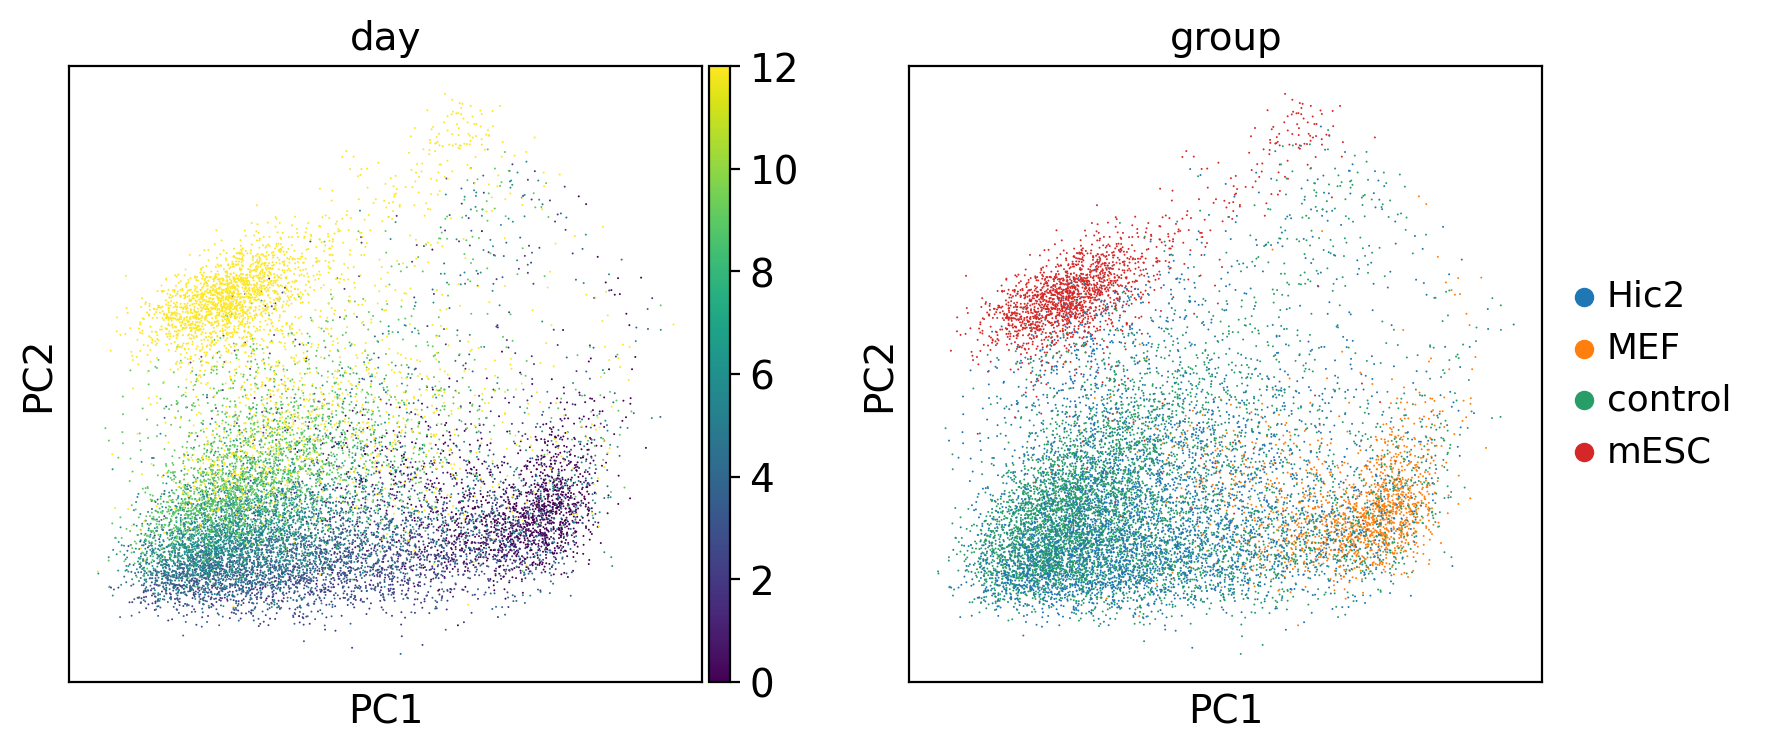

AnnData object with n_obs × n_vars = 13442 × 9531
    obs: 'sample', 'group', 'day', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
    var: 'ensembl_id', 'gene_symbol', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_count_corr'
    uns: 'log1p', 'pca', 'neighbors', 'group_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'


/home/love/miniconda3/envs/masters_project/lib/python3.13/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/love/miniconda3/envs/masters_project/lib/python3.13/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/love/miniconda3/envs/masters_project/lib/python3.13/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/love/miniconda3/envs/masters

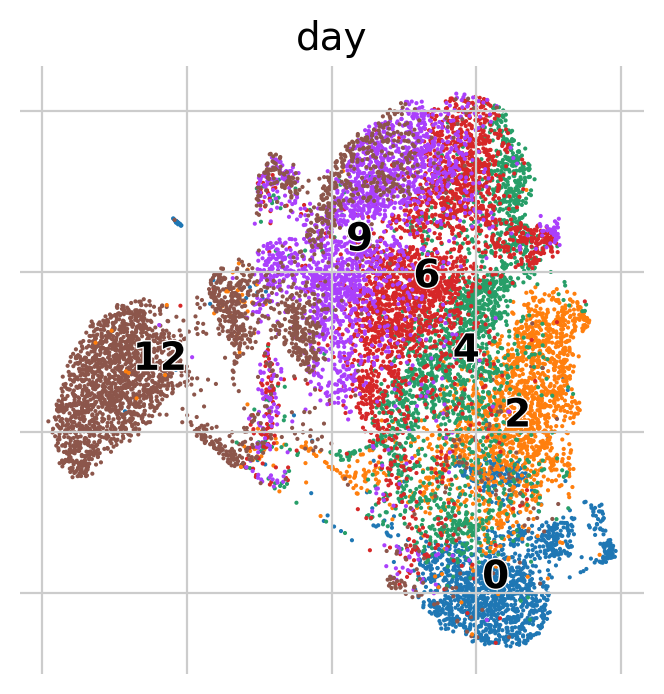

/home/love/miniconda3/envs/masters_project/lib/python3.13/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/love/miniconda3/envs/masters_project/lib/python3.13/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/love/miniconda3/envs/masters_project/lib/python3.13/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/love/miniconda3/envs/masters

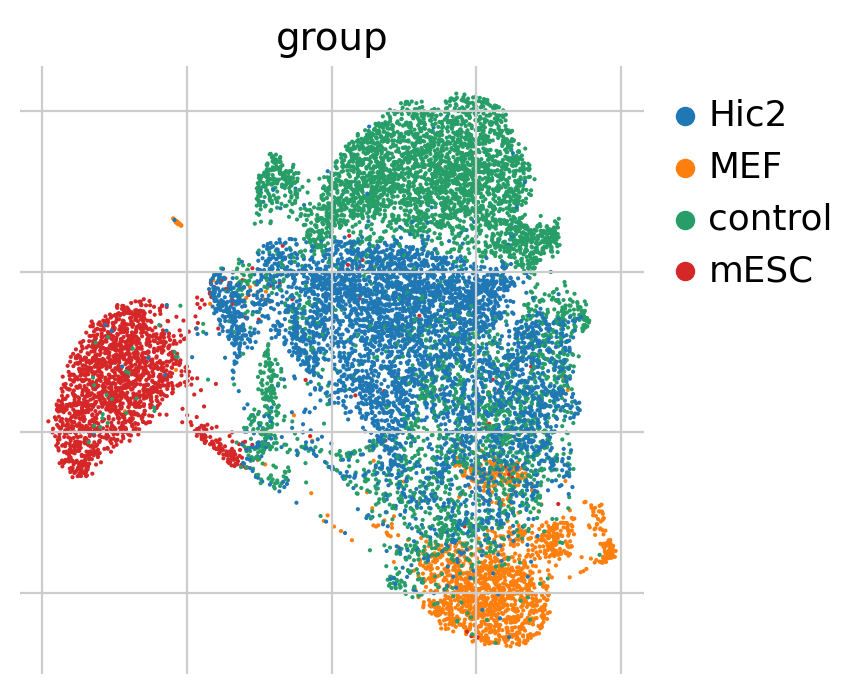

In [16]:
# Plot cells
scanpy.tl.pca(adata_velocity)
scanpy.pl.pca(
    adata_velocity,
    color=["day", "group"],
    ncols=2,
    size=2,
)
scanpy.tl.umap(adata_velocity)
print(adata_velocity)
scvelo.pl.scatter(adata_velocity, basis="umap", color=["day"])
scvelo.pl.scatter(adata_velocity, basis="umap", color=["group"])

In [17]:
# Calculate EM velocities

scvelo.tl.recover_dynamics(adata_velocity, n_jobs=15)

recovering dynamics (using 15/16 cores)


  0%|          | 0/1720 [00:00<?, ?gene/s]

/home/love/miniconda3/envs/masters_project/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=3861) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/home/love/miniconda3/envs/masters_project/lib/python3.13/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/home/love/miniconda3/envs/masters_project/lib/python3.13/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/home/love/miniconda3/envs/masters_project/lib/python3.13/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/home/love/minic

    finished (0:08:45) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


computing velocities


/home/love/miniconda3/envs/masters_project/lib/python3.13/site-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


    finished (0:00:06) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 15/16 cores)


  0%|          | 0/13442 [00:00<?, ?cells/s]

/home/love/miniconda3/envs/masters_project/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=3861) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


    finished (0:00:13) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/home/love/miniconda3/envs/masters_project/lib/python3.13/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/love/miniconda3/envs/masters_project/lib/python3.13/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/love/miniconda3/envs/masters_project/lib/python3.13/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/love/miniconda3/envs/masters

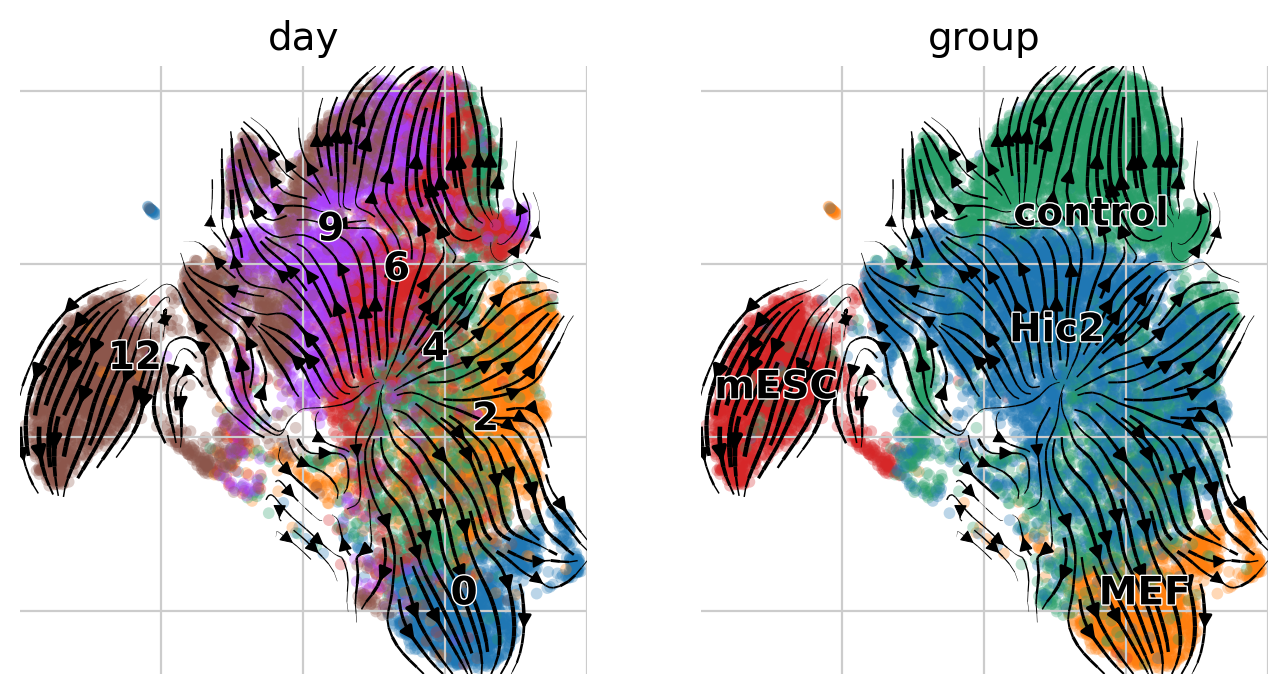

In [18]:
# Visualize EM velocities

scvelo.tl.velocity_graph(adata_velocity, n_jobs=15)
scvelo.pl.velocity_embedding_stream(adata_velocity, basis="umap", color=["day", "group"])

/home/love/miniconda3/envs/masters_project/lib/python3.13/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/love/miniconda3/envs/masters_project/lib/python3.13/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/love/miniconda3/envs/masters_project/lib/python3.13/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/love/miniconda3/envs/masters

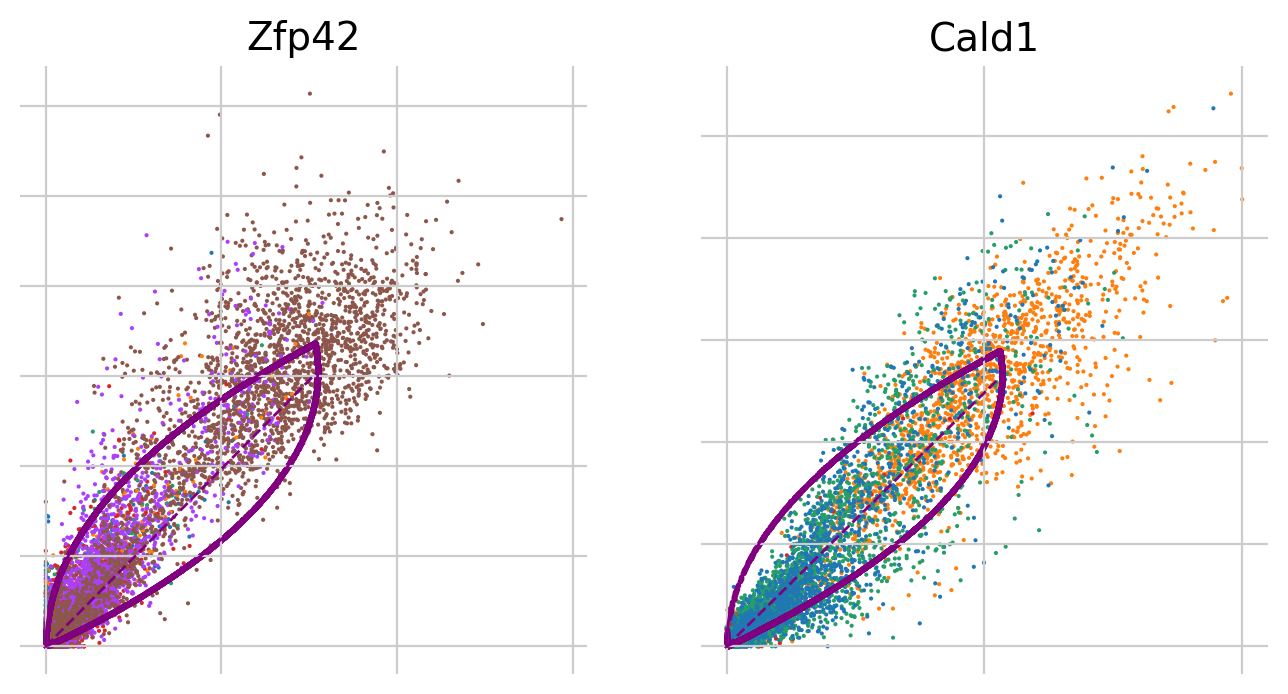

In [19]:
# Plot top genes
top_genes = adata_velocity.var["fit_likelihood"].sort_values(ascending=False).index
scvelo.pl.scatter(adata_velocity, basis=top_genes[:5], color=["day", "group"], frameon=False)

computing latent time using is_root, is_end as prior
    finished (0:00:06) --> added 
    'latent_time', shared time (adata.obs)


/home/love/miniconda3/envs/masters_project/lib/python3.13/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/love/miniconda3/envs/masters_project/lib/python3.13/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/love/miniconda3/envs/masters_project/lib/python3.13/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/love/miniconda3/envs/masters

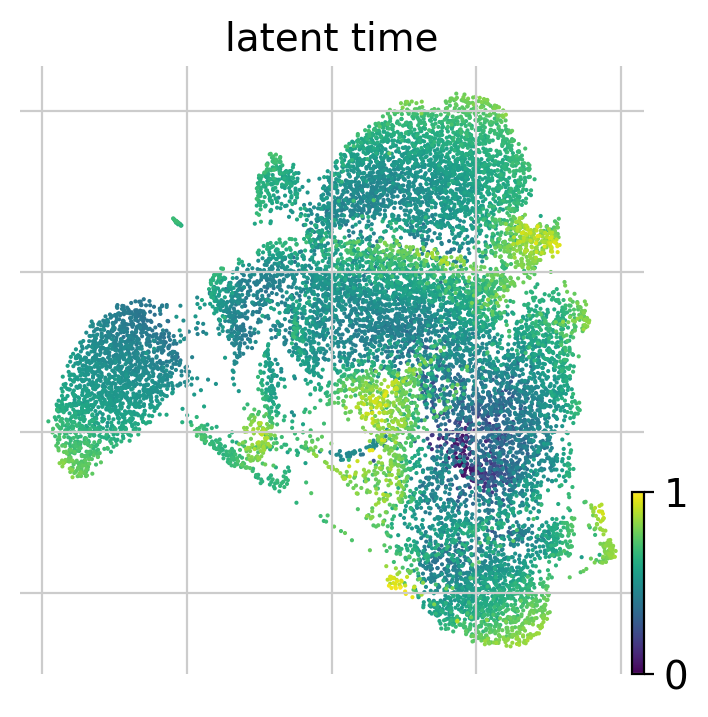

In [20]:
# Set MEFs as the root for latent time
# Create a boolean column in .obs
adata_velocity.obs["is_root"] = adata_velocity.obs["group"] == "MEF"
adata_velocity.obs["is_end"] = adata_velocity.obs["group"] == "mESC"

# Use that column as root_key
scvelo.tl.recover_latent_time(adata_velocity, root_key="is_root", end_key="is_end")

# Plot velocities colored by latent time
scvelo.pl.scatter(adata_velocity, color="latent_time", color_map="viridis")


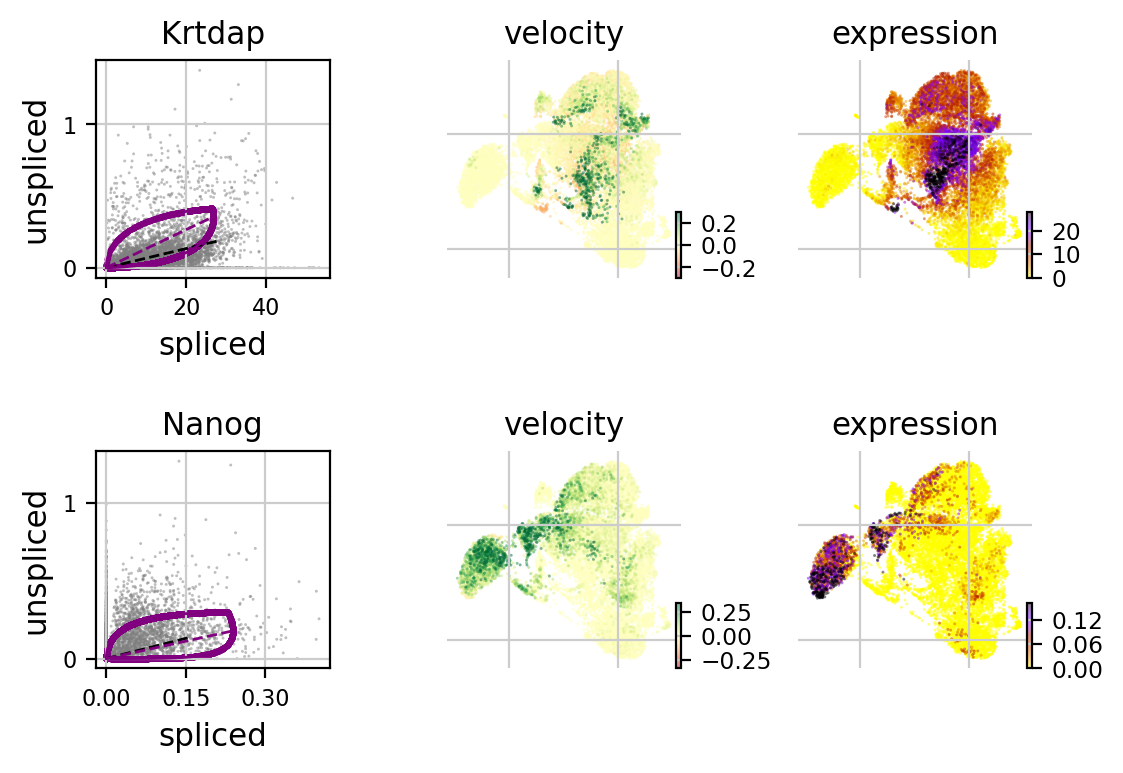

In [21]:
model_genes = ["Krtdap", "Hic2", "Nanog", "Klf4"]
scvelo.pl.velocity(adata_velocity, var_names=model_genes)

/home/love/miniconda3/envs/masters_project/lib/python3.13/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/love/miniconda3/envs/masters_project/lib/python3.13/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/love/miniconda3/envs/masters_project/lib/python3.13/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/love/miniconda3/envs/masters

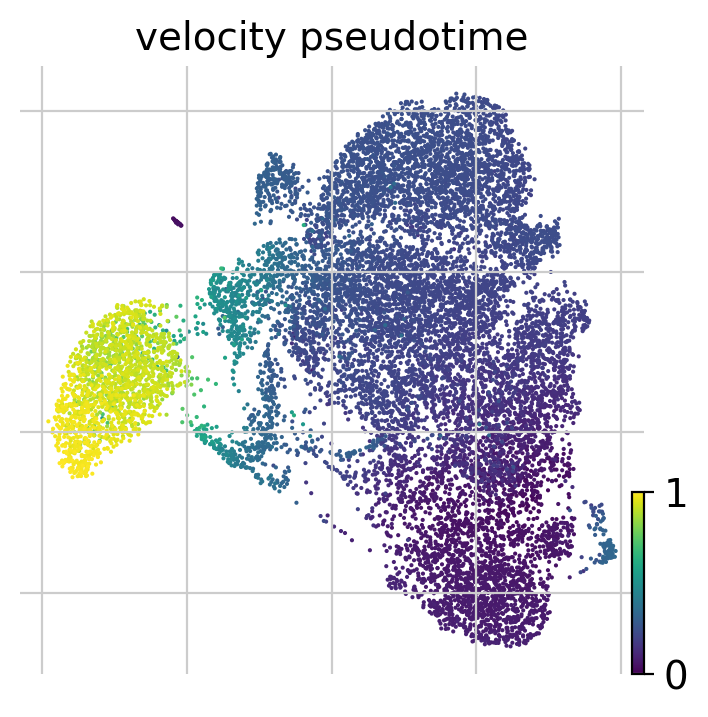

In [25]:
# Pseudotime
scvelo.tl.velocity_pseudotime(adata_velocity)
scvelo.pl.scatter(adata_velocity, color="velocity_pseudotime", color_map="viridis")

In [26]:
# Save analyzed adata
adata_velocity.write_h5ad(
    "RNA Sequencing Data/velocity_adata.h5ad",
    compression=hdf5plugin.FILTERS["zstd"]
)